<a href="https://colab.research.google.com/github/hyewonleess/MiraeAssetContest/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# 한글 폰트 설정
!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='NanumBarunGothic')

In [ ]:
train=pd.read_csv('/content/train.csv',header=0)
test=pd.read_csv('/content/test.csv',header=0)

In [ ]:
variable = ['ID','base_ym','dsas_ltwt_gcd','kcd_gcd','dsas_acd_rst_dcd','ar_rclss_cd','blrs_cd','mdct_inu_rclss_dcd','nur_hosp_yn','optt_nbtm_s','bilg_isamt_s','hspz_dys_s','hsp_avg_hspz_bilg_isamt_s','hsp_avg_optt_bilg_isamt_s',
            'hsp_avg_surop_bilg_isamt_s','hsp_avg_diag_bilg_isamt_s','dsas_avg_hspz_bilg_isamt_s','dsas_avg_optt_bilg_isamt_s','dsas_avg_surop_bilg_isamt_s','dsas_avg_diag_bilg_isamt_s','hspz_blcnt_s','surop_blcnt_s','optt_blcnt_s',
            'isrd_age_dcd','fds_cust_yn','smrtg_5y_passed_yn','mtad_cntr_yn','heltp_pf_ntyn','prm_nvcd','inamt_nvcd','ac_ctr_diff','ac_rst_diff','urlb_fc_yn','target']
variable_kor = ['접수일련번호','접수년월','질병경중등급코드','KCD등급코드','질병구분코드','발생지역구분코드','치료행위코드','의료기관구분코드','요양병원여부','통원횟수','청구보험금','입원일수','병원별평균입원청구보험금',
                '병원별평균통원청구보험금','병원별평균수술청구보험금','병원별평균진단청구보험금','질병별평균입원청구보험금','질병별평균통원청구보험금','질병별평균수술청구보험금','질병별평균진단청구보험금','입원청구건수',
                '수술청구건수','통원청구건수','고객나이구분코드','보험사기이력고객여부','부담보5년경과여부','중도부가계약여부','건강인우대계약여부','보험료구간코드','가입금액구간코드','청구일계약일간기간구분코드',
                '청구일부활일간기간구분코드','부실판매자계약여부','실사상태코드']

In [ ]:
train=train[variable]
train.columns=variable_kor

## 1. Data Exploration

In [ ]:
train.head()

,접수일련번호,접수년월,질병경중등급코드,KCD등급코드,질병구분코드,발생지역구분코드,치료행위코드,의료기관구분코드,요양병원여부,통원횟수,청구보험금,입원일수,병원별평균입원청구보험금,병원별평균통원청구보험금,병원별평균수술청구보험금,병원별평균진단청구보험금,질병별평균입원청구보험금,질병별평균통원청구보험금,질병별평균수술청구보험금,질병별평균진단청구보험금,입원청구건수,수술청구건수,통원청구건수,고객나이구분코드,보험사기이력고객여부,부담보5년경과여부,중도부가계약여부,건강인우대계약여부,보험료구간코드,가입금액구간코드,청구일계약일간기간구분코드,청구일부활일간기간구분코드,부실판매자계약여부,실사상태코드
0,0,201901,1,3,1,1,12,2,0,0.8571,0.4240,0.3452,1.6021,0.1303,0.0000,0.0000,1.2612,1.2002,1.1701,0.9793,10.0000,0.0,2.0,3,0,0,0,0,1,4,6,0,0,1
1,1,201901,3,8,22,4,2,1,1,0.0000,0.8602,0.0000,0.0000,0.0000,0.5770,0.0000,0.0023,0.0000,0.1508,0.0000,0.0000,1.0,0.0,4,0,0,0,0,1,4,6,0,0,0
2,2,201901,3,8,22,1,2,1,1,0.0000,0.4301,0.0000,0.0000,0.0000,0.2885,0.0000,0.0023,0.0000,0.1508,0.0000,0.0000,1.0,0.0,4,1,0,0,0,1,6,6,0,0,1
3,3,201901,3,8,23,2,8,2,0,0.0000,0.2509,0.8056,0.5638,0.0197,0.0680,0.0587,0.1920,0.0000,0.0863,0.0000,1.4444,0.0,0.0,9,0,0,0,0,1,6,4,0,0,1
4,4,201901,3,8,23,9,8,2,0,0.0000,0.0323,0.4167,0.4464,0.0000,0.0000,0.0000,0.1920,0.0000,0.0863,0.0000,1.3333,0.0,0.0,0,0,0,0,0,2,2,5,0,0,1


### (1) target 분포
Train data 의 타겟 분포가 불균형하다. 1에 해당하는 '심사' 건이 가장 많이 차지하고, 그 다음으로는 0에 해당하는 '자동지급' 건수가 많다.

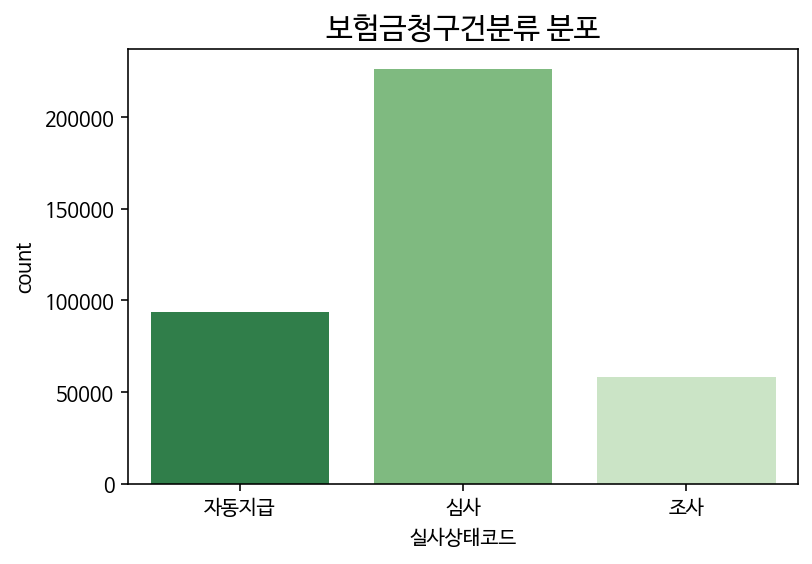

In [ ]:
target_count=train['실사상태코드'].value_counts().reset_index().rename(columns={'index':'실사상태코드','실사상태코드':'count'})
sns.barplot(data=target_count,x='실사상태코드',y='count',palette='Greens_r'); plt.title('보험금청구건분류 분포',fontsize=15);plt.xticks([0,1,2],['자동지급','심사','조사'])
plt.show()

## (2) Column dtypes 

### 1) 정수형 변수

In [ ]:
df=train.drop(['접수일련번호'],axis=1)

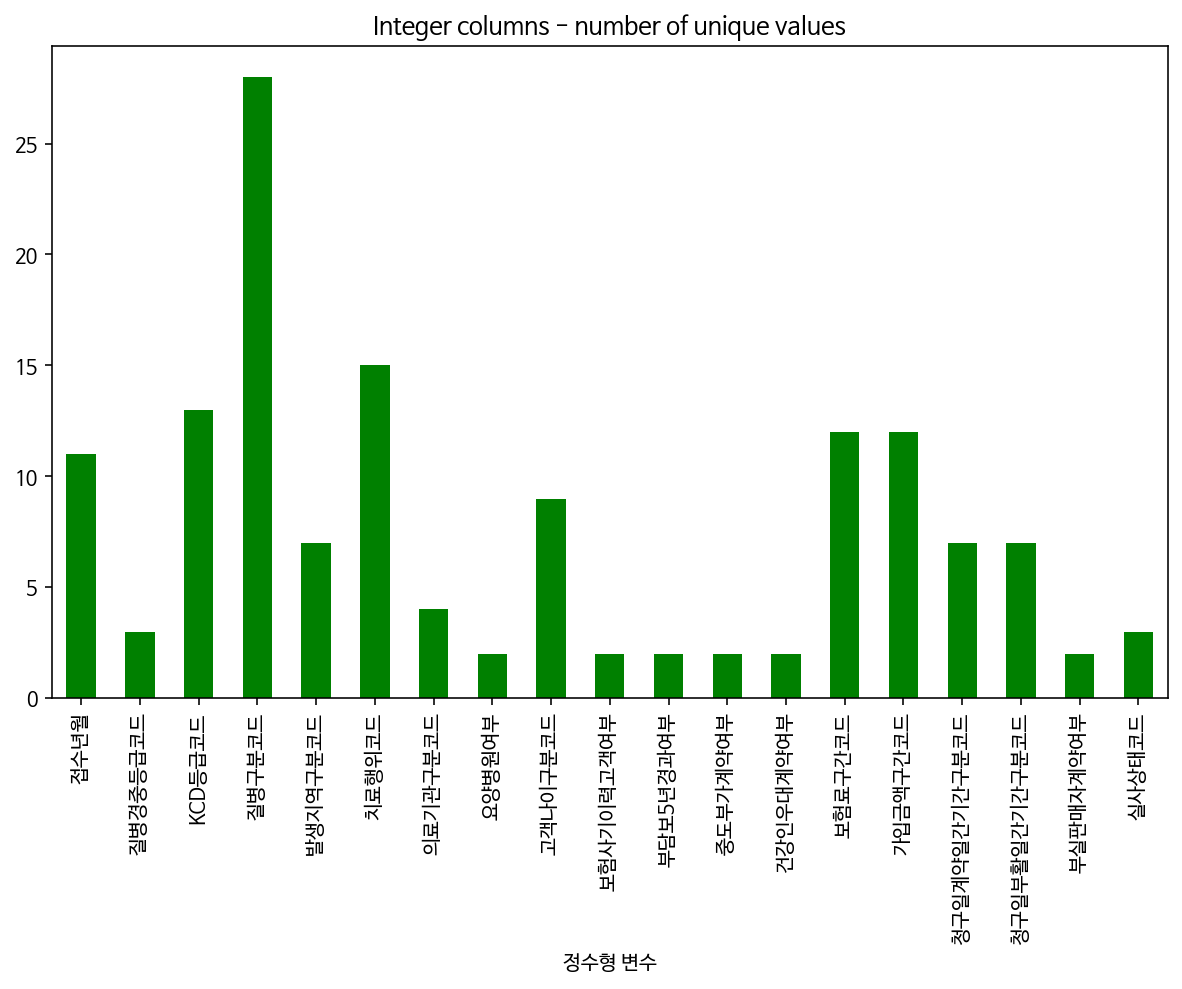

In [ ]:
df.select_dtypes(np.int64).nunique().plot.bar(color='green',figsize=(10,6))
plt.title('Integer columns - number of unique values'); plt.xlabel('정수형 변수');

### 2) Float 변수
+ 질병데이터에서 _s 로 끝나는 모든 변수가 Float 변수
+ 다음 변수들 값이 낮을수록 '자동지급'인 경향이 높다 <br>
입원일수(`hspz_dys_s`), 병원별입원청구보험금(`hsp_avg_hspz_bilg_iasmt_s`), 질병별평균수술청구보험금(`dsas_avg_surop_bilg_isamt_s`), 청구보험금(`bilg_isamt_s`)
+ '자동지급' 으로 분류된 경우가 거의 없는 변수 <br>
통원횟수(`optt_nbtm_s`), 질병별평균진단청구보험금(`dsas_avg_diag_bilg_isamt_s`)

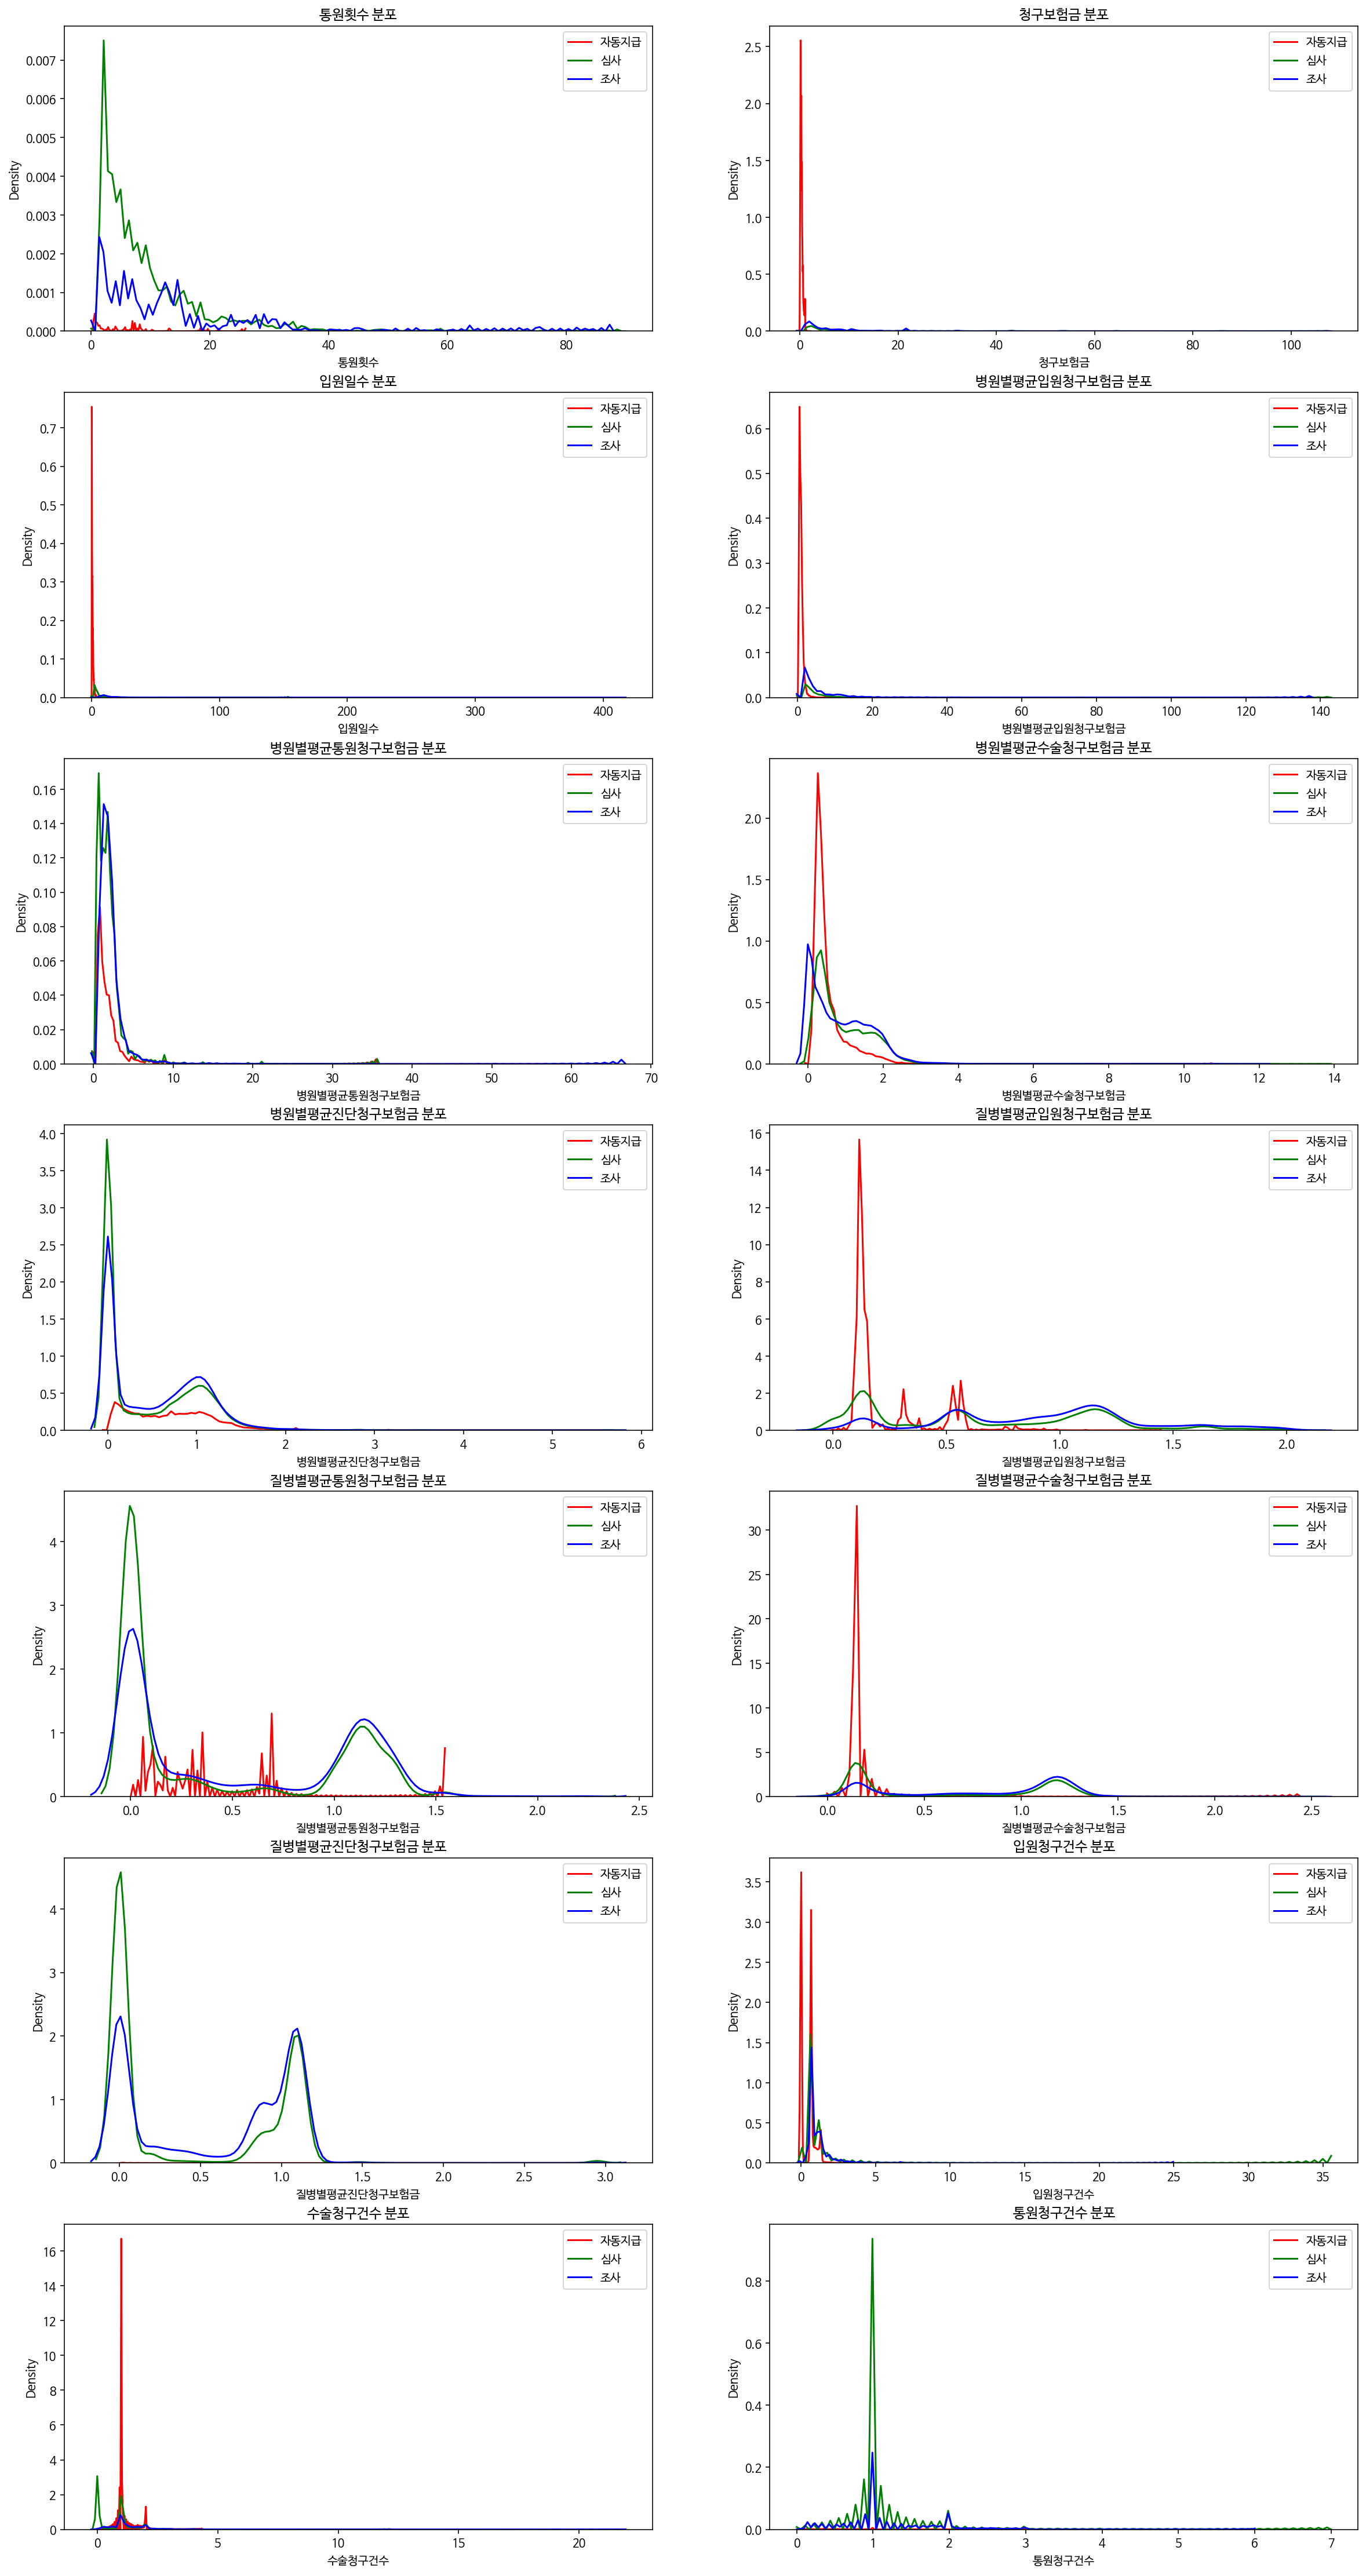

In [ ]:
from collections import OrderedDict

plt.figure(figsize=(20,16))


colors=OrderedDict({0:'red',1:'green',2:'blue'})
target_map=OrderedDict({0:'자동지급',1:'심사',2:'조사'})

for i,col in enumerate(train.select_dtypes('float')):
    ax=plt.subplot(7,2,i+1)
    for standard,color in colors.items():
        sns.kdeplot(train.loc[train['실사상태코드']==standard,col].dropna(),
                   ax=ax,color=color,label=target_map[standard])
    plt.title(f'{col.capitalize()} 분포');
    plt.xlabel(f'{col}');plt.ylabel('Density')
plt.subplots_adjust(top=2)

## (3) 결측치 

In [ ]:
# 결측치 없음
train.isnull().sum()

접수일련번호           0
접수년월             0
질병경중등급코드         0
KCD등급코드          0
질병구분코드           0
발생지역구분코드         0
치료행위코드           0
의료기관구분코드         0
요양병원여부           0
통원횟수             0
청구보험금            0
입원일수             0
병원별평균입원청구보험금     0
병원별평균통원청구보험금     0
병원별평균수술청구보험금     0
병원별평균진단청구보험금     0
질병별평균입원청구보험금     0
질병별평균통원청구보험금     0
질병별평균수술청구보험금     0
질병별평균진단청구보험금     0
입원청구건수           0
수술청구건수           0
통원청구건수           0
고객나이구분코드         0
보험사기이력고객여부       0
부담보5년경과여부        0
중도부가계약여부         0
건강인우대계약여부        0
보험료구간코드          0
가입금액구간코드         0
청구일계약일간기간구분코드    0
청구일부활일간기간구분코드    0
부실판매자계약여부        0
실사상태코드           0
dtype: int64

## 2. EDA

**변수 속성별로 나누기**

In [ ]:
id_=['접수일련번호','접수년월','실사상태코드'] 

# 고객정보
customer_order='고객나이구분코드' # 체크
customer_bool='보험사기이력고객여부' 
# 상품정보
products_bool=['부담보5년경과여부','중도부가계약여부','건강인우대계약여부']
products_order=['보험료구간코드','가입금액구간코드','청구일계약일간기간구분코드','청구일부활일간기간구분코드']
# 판매자정보
seller='부실판매자계약여부'
# 질병정보
disease_bool='요양병원여부'
disease_order=['질병경중등급코드','KCD등급코드','질병구분코드','발생지역구분코드','치료행위코드','의료기관구분코드']
disease_conti=[x for x in train.columns if (x.endswith('보험금') or x.endswith('수'))]

### (1) 고객 & 판매자 데이터
 + 30~40대 고객 수가 가장 많다
 + 데이터 오류: 카테고리 7, 9가 없다

#### 1) 고객나이구분코드

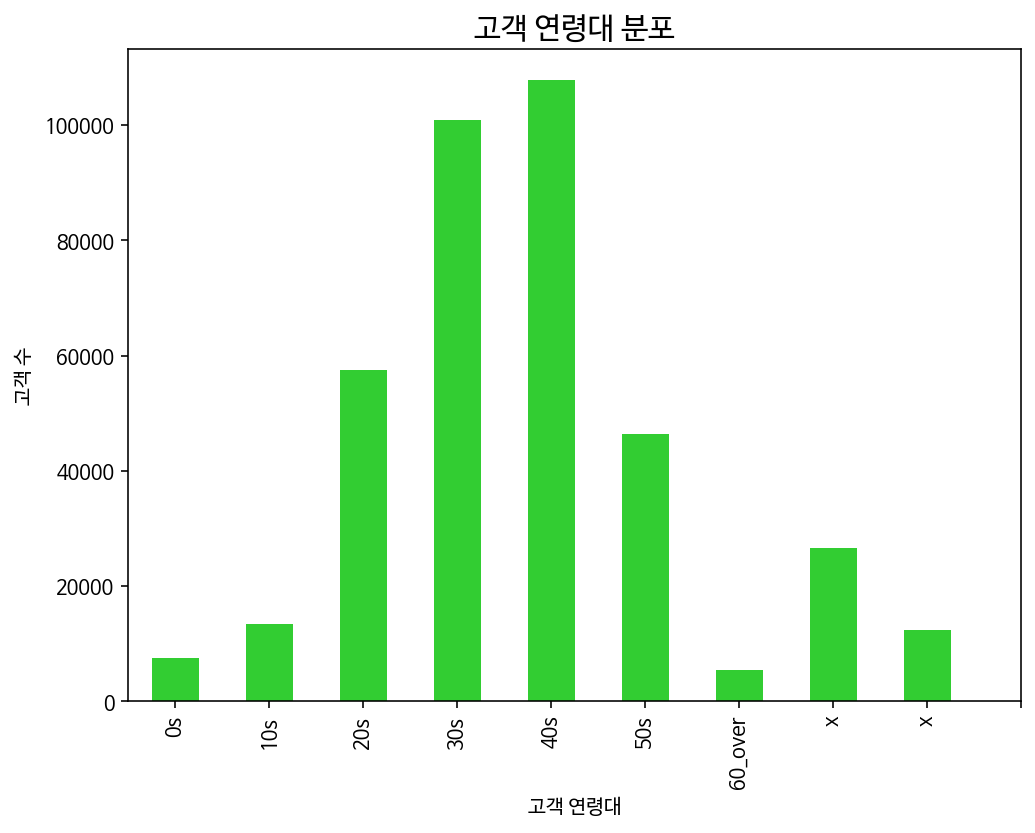

In [ ]:
train[customer_order].value_counts().sort_index().plot.bar(color='limegreen',figsize=(8,6))
plt.title('고객 연령대 분포',fontsize=15);plt.xlabel('고객 연령대');plt.ylabel('고객 수'); plt.xticks(range(0,10),['0s','10s','20s','30s','40s','50s','60_over','x','x']);
plt.show()

**고객연령의 타겟 분포**
 + 연령대가 높아질수록 자동지급 비율은 낮아지고 조사 비율은 증가하는 경향을 보임
 + 특이사항: 카테고리 7에 속하는 고객은 대부분 '조사'로 분류되었음
 

Text(0, 0.5, '비율(%)')

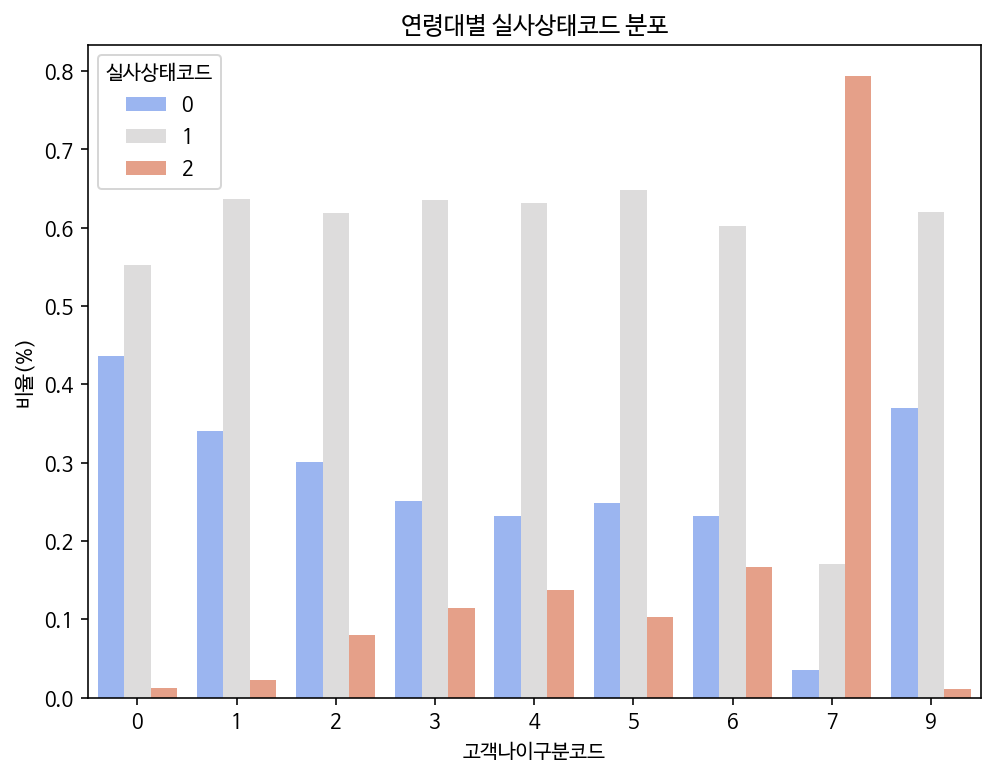

In [ ]:
age_group=train.groupby([customer_order,'실사상태코드'])['접수년월'].count()
age_group=age_group/age_group.groupby(level=0).sum()
age_group=age_group.reset_index().rename(columns={'접수년월':'비율'})

plt.figure(figsize=(8,6))
sns.barplot(data=age_group,x='고객나이구분코드',y='비율',hue='실사상태코드',palette='coolwarm')
plt.title('연령대별 실사상태코드 분포');plt.ylabel('비율(%)')

In [ ]:
# 타겟별 변수 count stacking 함수
def bar_stack_target(df,x_var):
  group=df.groupby([x_var,'실사상태코드'])['접수년월'].count()
  group=group/group.groupby(level=0).sum()
  group=group.reset_index().rename(columns={'접수년월':'비율'})

  sns.barplot(data=group,x=x_var,y='비율',hue='실사상태코드',palette='coolwarm')
  plt.title(f'{x_var}별 실사상태코드 분포',fontsize=15); plt.ylabel('비율(%)')
  plt.show()

#### 2) 보험사기이력고객 <br>
+ 보험사기이력이 없는 고객이 있는 고객보다 월등히 많음 
+ 보험사기이력이 있는 경우, '조사'로 분류되는 비율이 높고, '자동지급'으로 분류되는 비율이 낮음

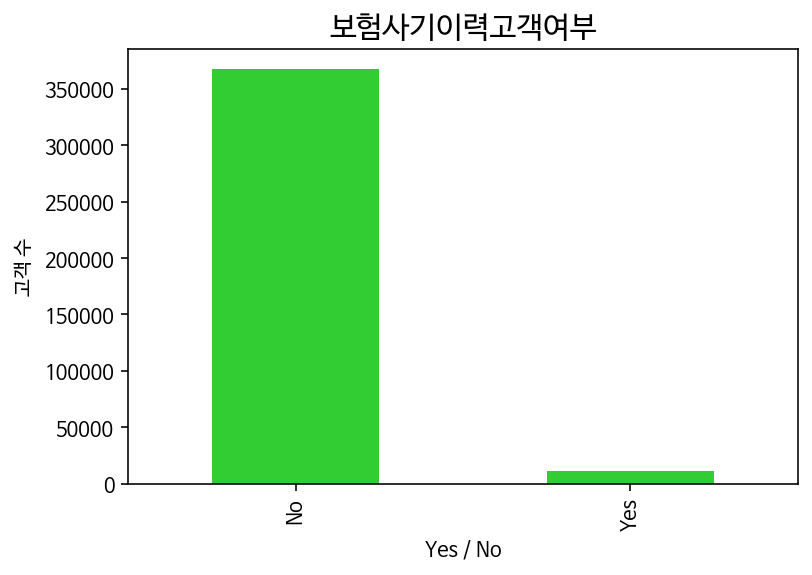

In [ ]:
train[customer_bool].value_counts().sort_index().plot.bar(color='limegreen',figsize=(6,4))
plt.title('보험사기이력고객여부',fontsize=15);plt.xlabel('Yes / No');plt.ylabel('고객 수'); plt.xticks([0,1],['No','Yes']);
plt.show()

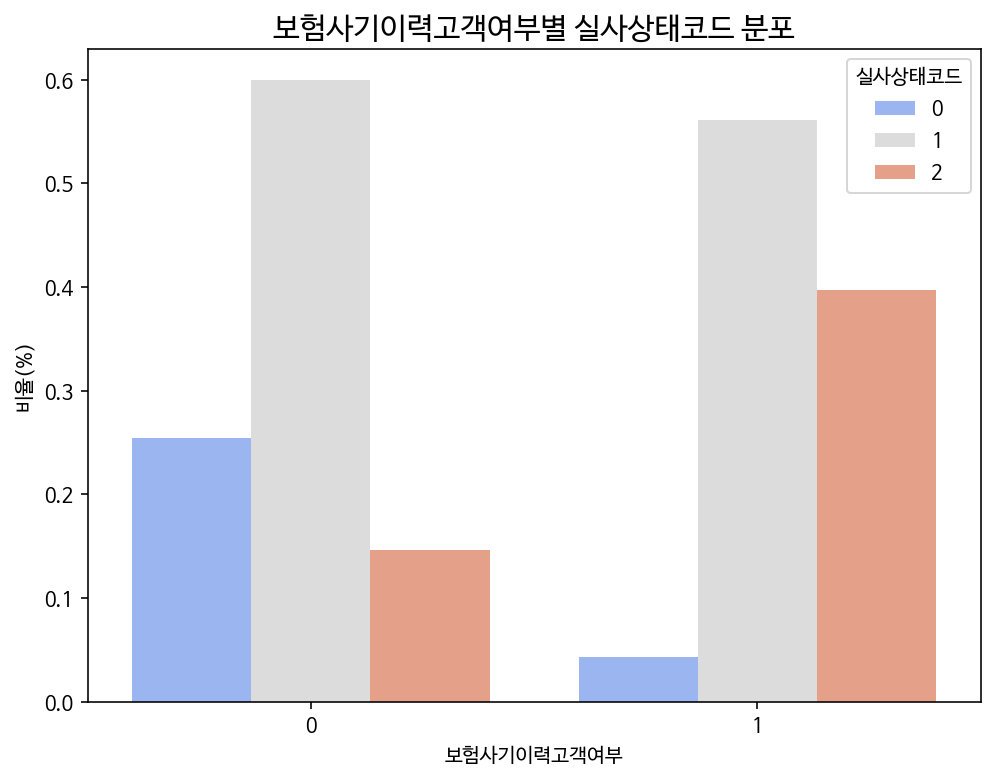

In [ ]:
plt.figure(figsize=(8,6))
bar_stack_target(train,'보험사기이력고객여부')

### (2) 상품 데이터
+ products_bool: `부담보5년경과여부`,`중도부가계약여부`,`건강인우대계약여부`
+ products_order: `보험료구간코드`,`가입금액구간코드`, `청구일계약일간기간구분코드`,`청구일부활일간기간구분코드`

#### 1) 상품 - Yes/No data
+ 부담보5년경과여부의 경우, 실사상태코드의 분포 차이가 거의 없다
+ 중도가계약, 건강인우대계약을 했을 때, '조사'로 분류된 고객이 거의 없다.

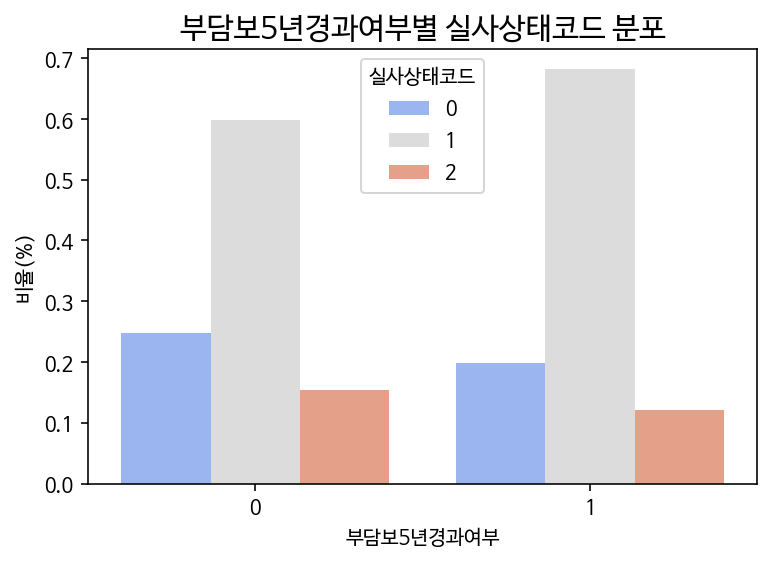

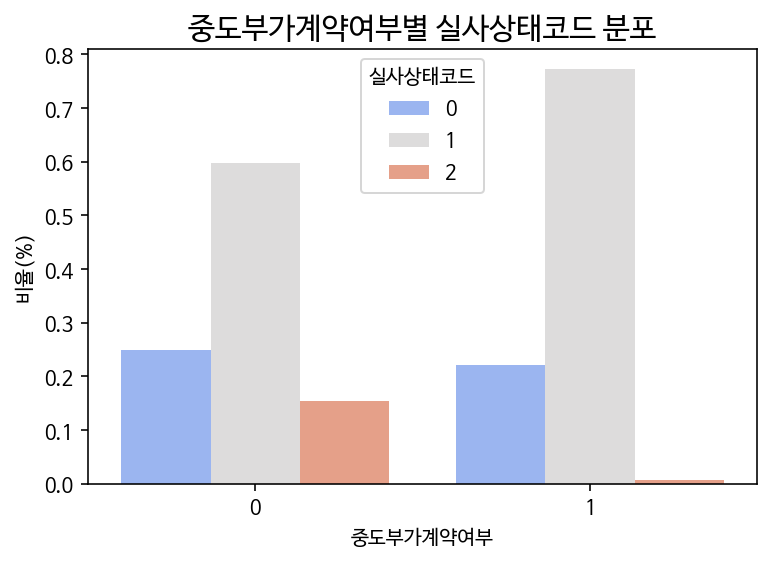

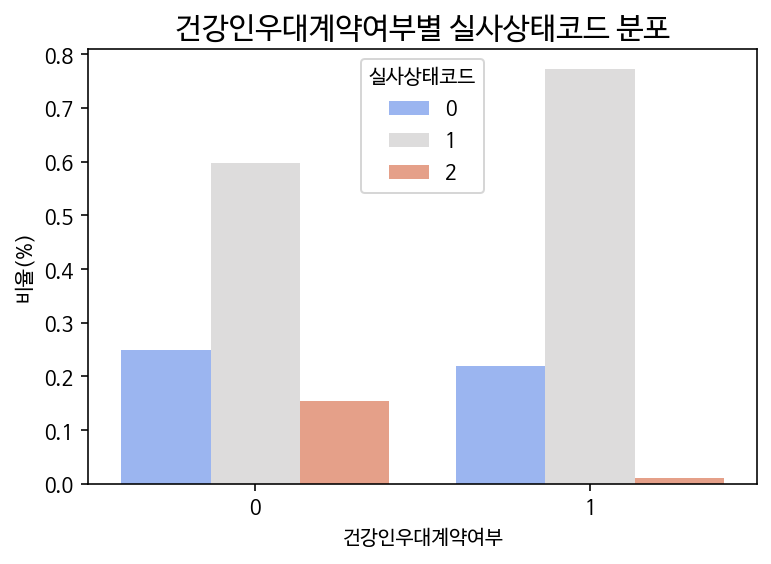

In [ ]:
for i,col in enumerate(products_bool):
  bar_stack_target(train,col)

#### 2) 상품 - Ordinal data

**Correlation Heatmap**
+ `보험료구간코드` - `가입금액구간코드` - `청구일계약일간기간구분코드` 상관관계가 매우 높음

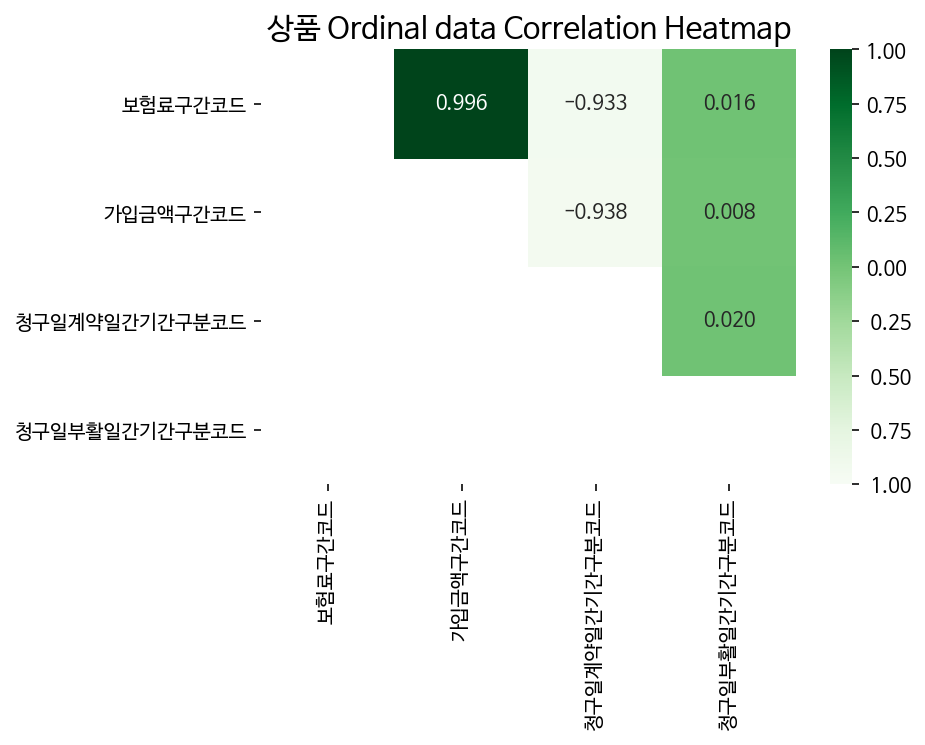

In [ ]:
corr_mat=train[products_order].corr()
mask=np.zeros_like(corr_mat,dtype=np.bool)
mask[np.tril_indices_from(mask)]=True

sns.heatmap(corr_mat,annot=True,cmap='Greens',mask=mask, vmax=1,vmin=-1,fmt='.3f')
plt.title('상품 Ordinal data Correlation Heatmap',fontsize=15)
plt.show()

In [ ]:
# Correlation Heatmap 그리는 함수
def corr_heatmap(df,col_list):
  corr_mat=df[col_list].corr()
  mask=np.zeros_like(corr_mat,dtype=np.bool)
  mask[np.tril_indices_from(mask)]=True

  sns.heatmap(corr_mat,annot=True,cmap='Greens',mask=mask, vmax=1,vmin=-1,fmt='.3f')
  plt.title('상품 Ordinal data Correlation Heatmap',fontsize=15)
  plt.show()

**보험료구간코드** <br>
대부분의 고객들이 납입하는 보험료는 보험료구간 1 (0~10만원 미만) 속한다. 첨부된 보험료구간코드 정보를 보면, 99에 해당하는 데이터는 'Unknown'에 속하는데, 보험료구간 1 다음으로 많은 고객들이 99에 해당한다. 


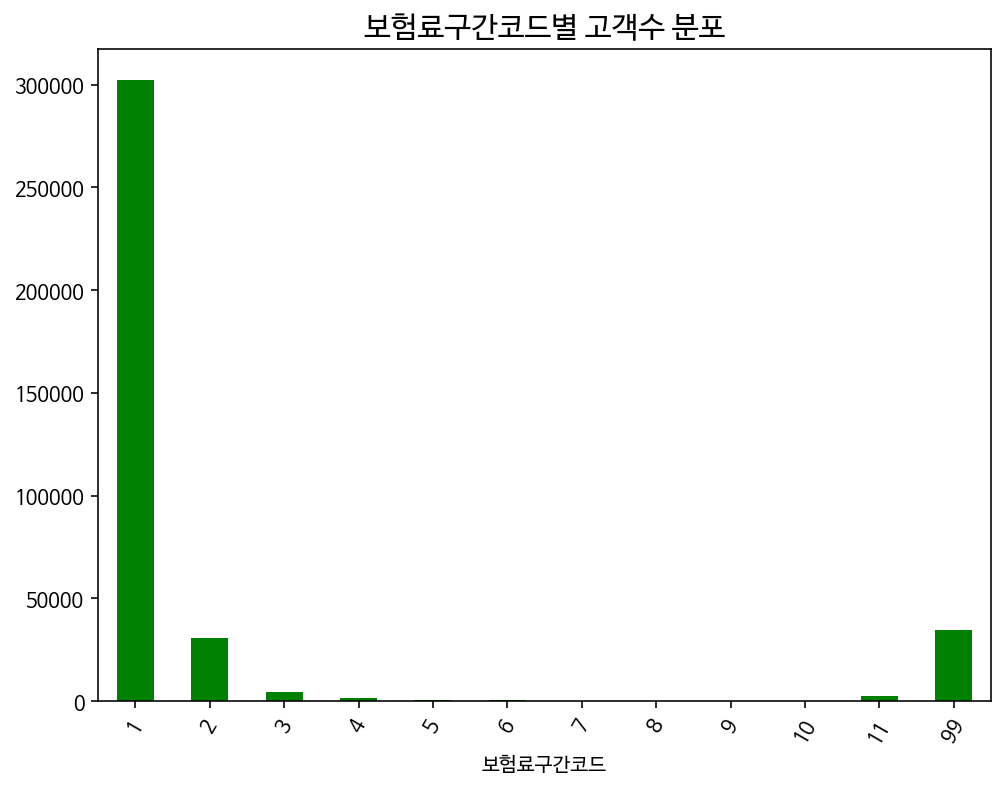

In [ ]:
train['보험료구간코드'].value_counts().sort_index().plot.bar(color='green',figsize=(8,6))
plt.title('보험료구간코드별 고객수 분포',fontsize=15);plt.xticks(rotation=60);plt.xlabel('보험료구간코드'); 
plt.show()

`보험료구간코드` 99(Unknown)에 해당하는 데이터는 동시에 `가입금액구간코드` 99(Unknown)에 속한다. 이에 해당하는 데이터는 전체의 약 9%.

In [ ]:
train.loc[(train['보험료구간코드']==99) & (train['가입금액구간코드']==99),['보험료구간코드','가입금액구간코드']]

,보험료구간코드,가입금액구간코드
7,99,99
50,99,99
96,99,99
105,99,99
108,99,99
...,...,...
377919,99,99
377920,99,99
377922,99,99
377924,99,99


**`보험료구간코드` 및 `가입금액구간코드` 99에 해당하는 고객은 '조사'로 가장 많이 분류되었다. --> 보험료 Unknown 이 보험금청구권분류 시 부정적으로 작용하는듯?** <br>
 + 방법1: 새로운 변수 만들기: ex) Unknown 에 해당하면 1, 아니면 0 부여하는 boolean형 변수 ?
 + 방법2: 다른값으로 대체(?) 하지만 비슷한 분포를 띄는 카테고리가 없다...

1.   항목 추가
2.   항목 추가



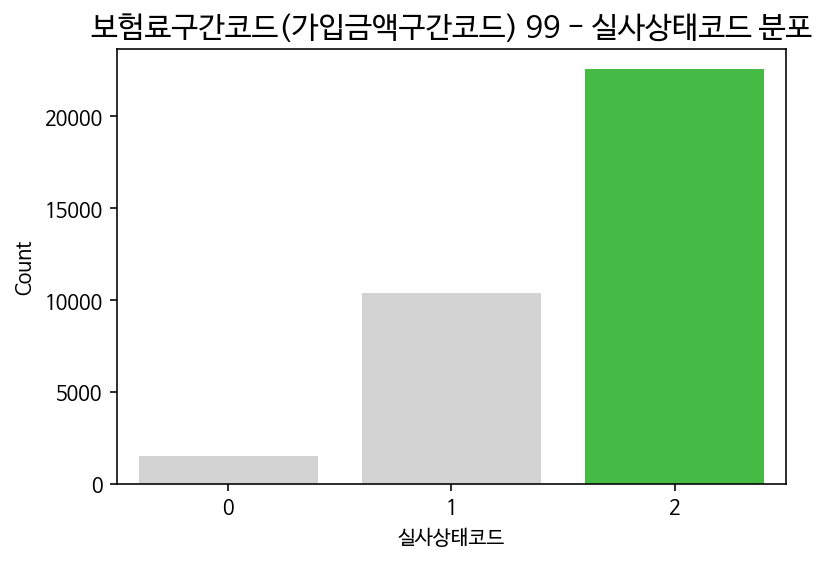

In [ ]:
# Unknown 에 해당하는 데이터의 Target 분포
prm_99=train[train['보험료구간코드']==99].groupby(['실사상태코드'])['접수년월'].count().reset_index().rename(columns={'접수년월':'Count'})
colors=['limegreen' if (x == max(prm_99['Count']))
        else 'lightgrey'  for x in prm_99['Count']]
sns.barplot(data=prm_99,x='실사상태코드',y='Count',palette=colors); plt.title('보험료구간코드(가입금액구간코드) 99 - 실사상태코드 분포',fontsize=15)
plt.show()

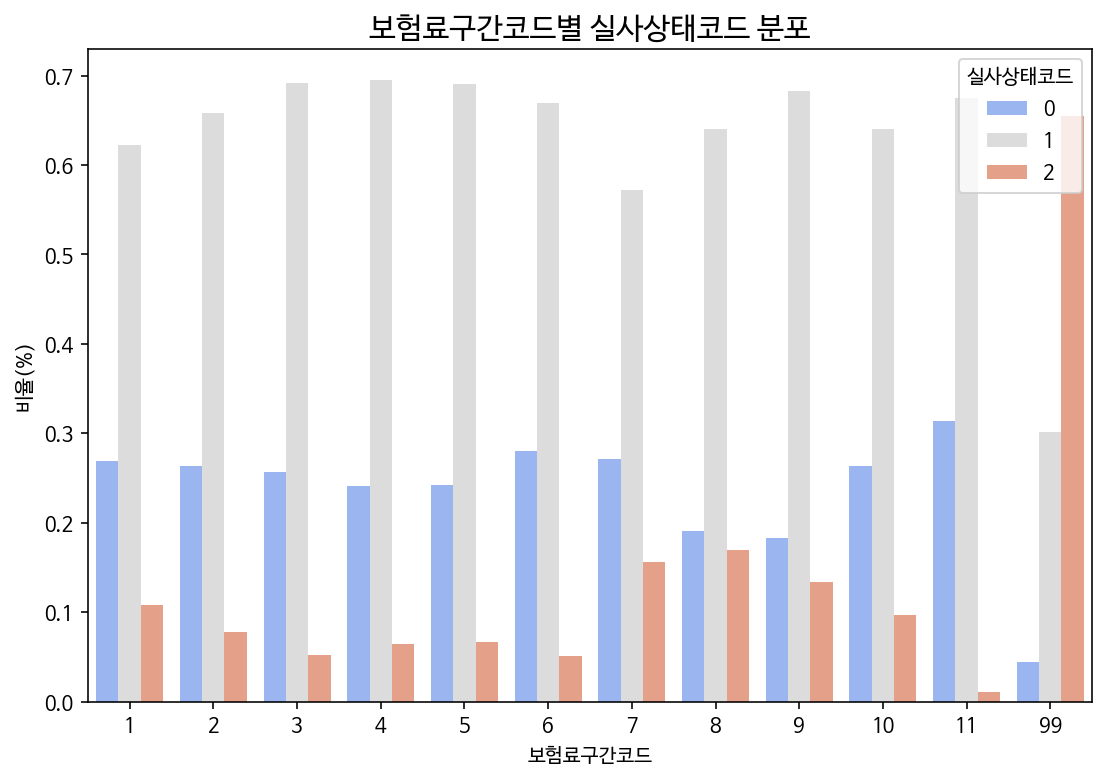

In [ ]:
plt.figure(figsize=(9,6))
bar_stack_target(train,'보험료구간코드')

**청구일계약일간기간구분코드** <br>
+ 보험료구간코드(99) - 가입금액구간코드(99) - 청구계약일간기간구분코드(0): Unknown 값들은 항상 같은 데이터에 있음

In [ ]:
train.loc[(train['보험료구간코드']==99) & (train['가입금액구간코드']==99) & (train['청구일계약일간기간구분코드']==0) ,['보험료구간코드','가입금액구간코드','청구일계약일간기간구분코드']]

,보험료구간코드,가입금액구간코드,청구일계약일간기간구분코드
7,99,99,0
50,99,99,0
96,99,99,0
105,99,99,0
108,99,99,0
...,...,...,...
377919,99,99,0
377920,99,99,0
377922,99,99,0
377924,99,99,0


### (3) 질병 데이터 
 + disease_bool: `요양병원여부`
 + disease_order: `질병경중등급코드`,`KCD등급코드`,`질병구분코드`,`발생지역구분코드`,`치료행위코드`,`의료기관구분코드`
 + disease_conti: 나머지 질병 변수


#### 1) 질병 - Yes/No data
+ 요양병원여부가 Yes 이면 No인 경우보다 실사상태코드가 0인 비율이 더 높아지고 2인 비율은 낮아짐

In [ ]:
train[disease_bool].value_counts()

0    289773
1     88155
Name: 요양병원여부, dtype: int64

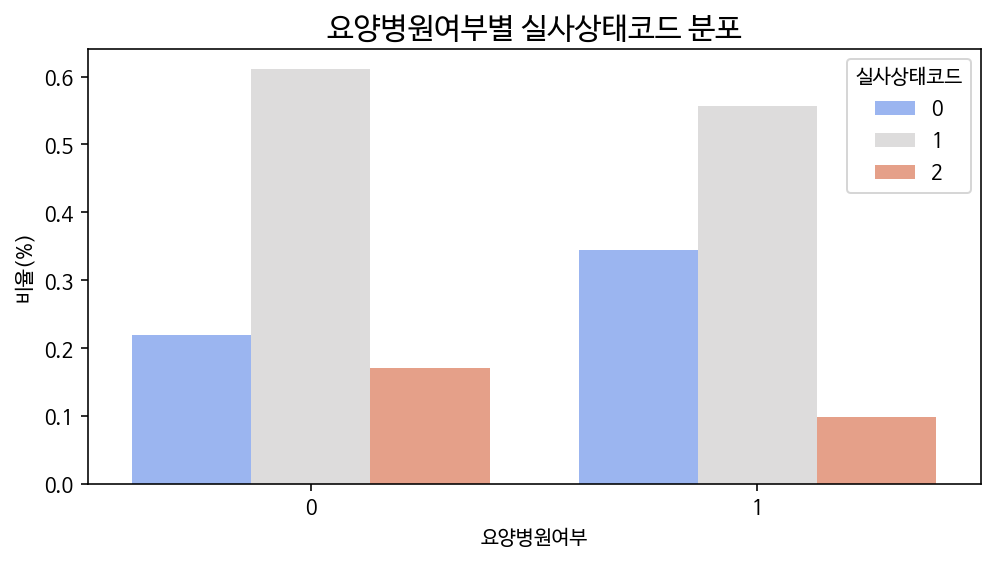

In [ ]:
plt.figure(figsize=(8,4))
bar_stack_target(train,'요양병원여부')

#### 2) 질병 - Ordinal data

`질병경중등급코드` 와 `질병구분코드`가 높은 상관관계를 보인다. 두 변수 모두 질병을 카테고리로 구분하는 변수!

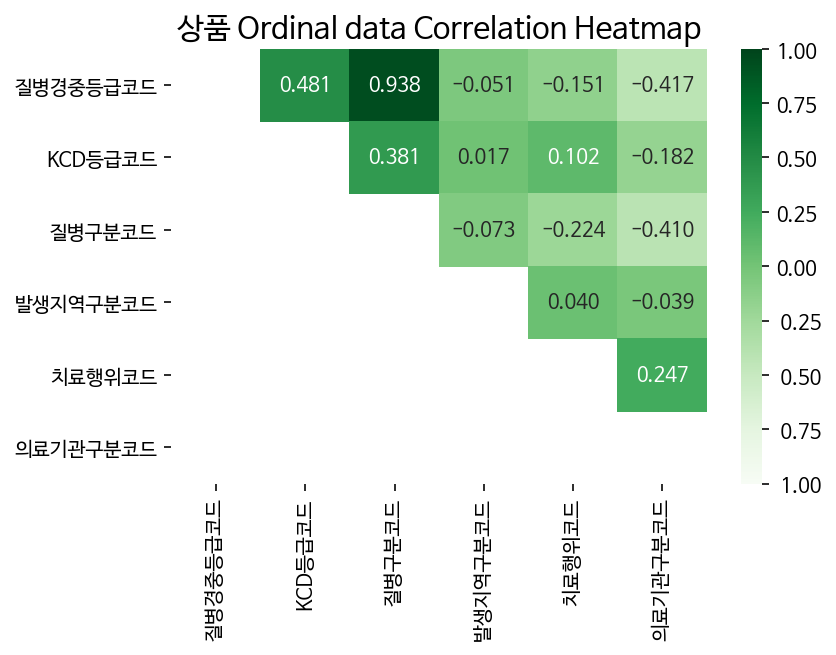

In [ ]:
corr_mat=train[disease_order].corr()
mask=np.zeros_like(corr_mat,dtype=np.bool)
mask[np.tril_indices_from(mask)]=True

sns.heatmap(corr_mat,annot=True,cmap='Greens',mask=mask, vmax=1,vmin=-1,fmt='.3f')
plt.title('상품 Ordinal data Correlation Heatmap',fontsize=15)
plt.show()

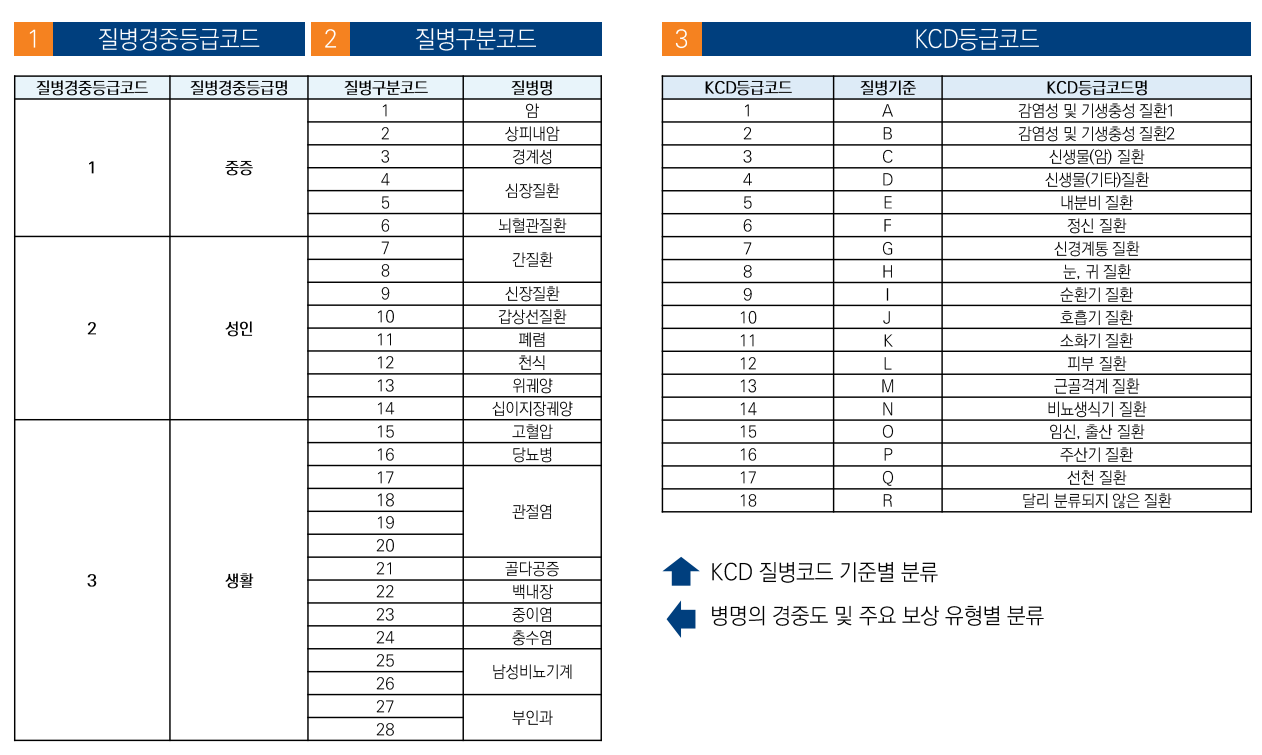

위의 질병코드 분류를 보면, `질병경중등급코드` 안에 `질병구분코드`가 속해있기 때문에 correlation이 높게 나오는 것으로 보인다. 두 변수 중 한 변수만 선택해도 될듯!

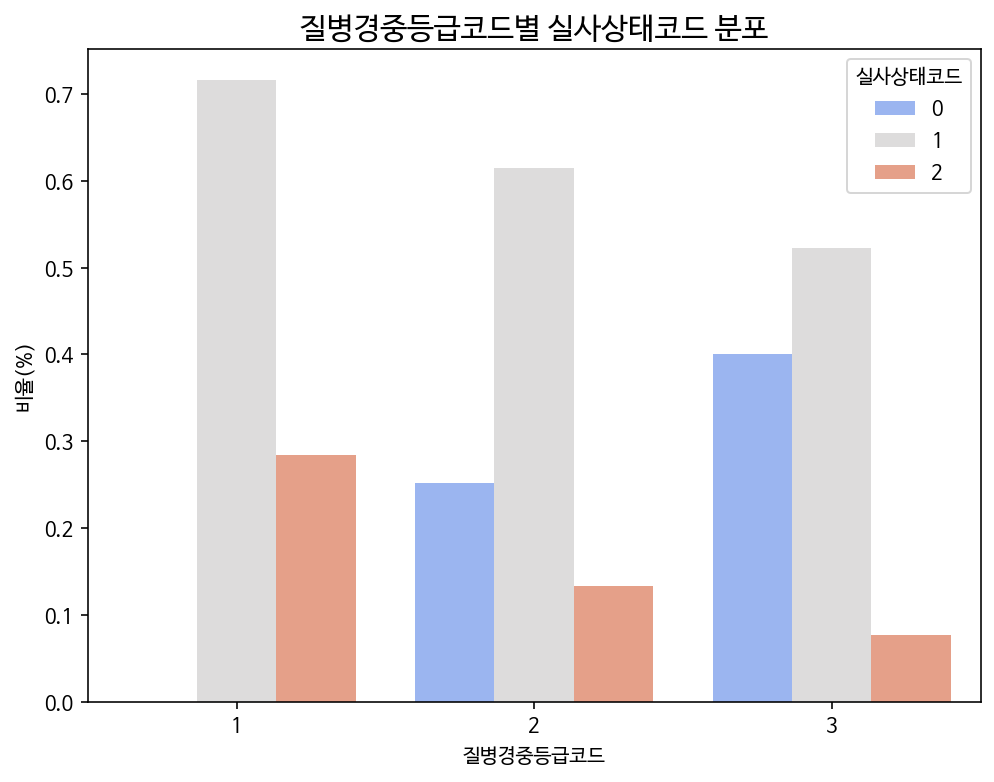

In [ ]:
plt.figure(figsize=(8,6))
bar_stack_target(train,'질병경중등급코드')

그냥 궁금한점) 질병구분코드는 암인데 KCD 등급 코드는 감염성 및 신생물(기타)질환으로 분류된 경우가 있다. (아래 데이터 참고)

In [ ]:
disease_group=train.groupby(['질병구분코드','KCD등급코드'])['접수년월'].count().reset_index().rename(columns={'접수년월':'Count'})
disease_group

,질병구분코드,KCD등급코드,Count
0,1,2,10
1,1,3,89004
2,1,4,41
3,2,2,3
4,2,3,1016
...,...,...,...
199,27,9,1
200,27,11,1
201,27,13,1
202,27,14,21159


`KCD등급코드` 가 18 인 데이터(달리 분류되지 않은 질환)은 존재하지 않는다.

In [ ]:
disease_group[disease_group['KCD등급코드']==18]

,질병구분코드,KCD등급코드,Count


**의료기관구분코드** <br>
 + Unknown 데이터 존재 - 카테고리 9
 + 일방병원(0) > 종합병원(1) > 상급종합병원(2) 순으로 `실사상태코드`가 '자동지급'으로 분류된 비율이 높음

In [ ]:
# 카테고리 9에 해당하는 데이터가 전체의 0.051% 만 차지하므로 제거하는게 좋을 것 같다.
의료9_percent=len(train[train['의료기관구분코드']==9])/len(train)*100
print('의료기관구분코드 9에 해당하는 데이터의 비율: ', np.round(의료9_percent,3) ,'%' )

의료기관구분코드 9에 해당하는 데이터의 비율:  0.051 %


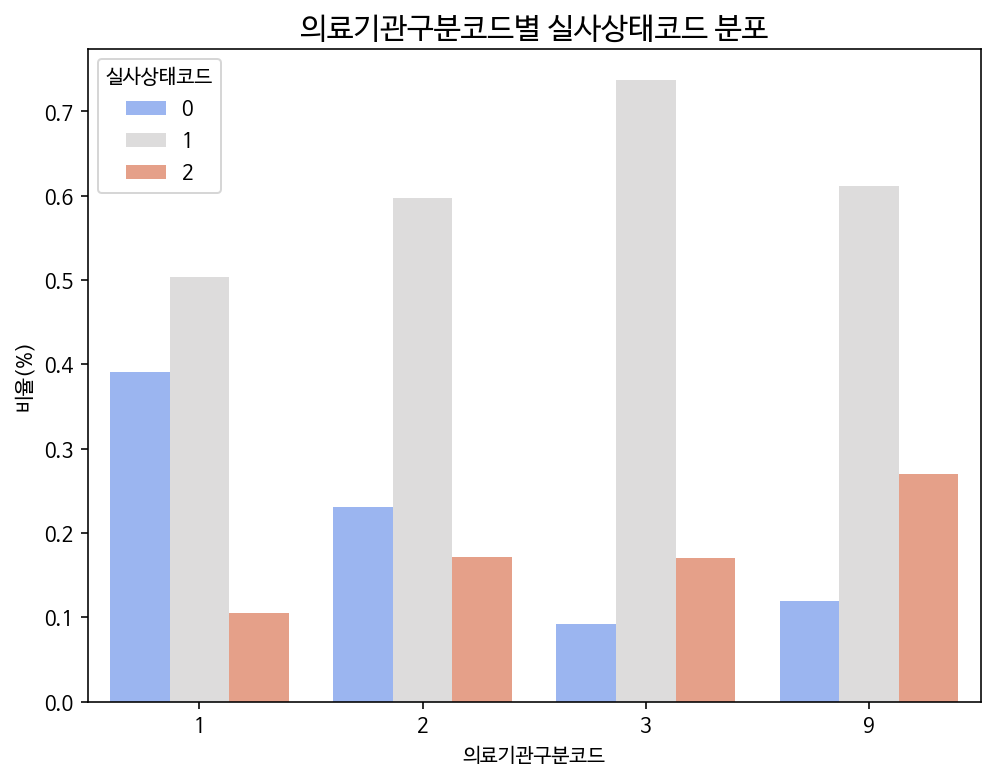

In [ ]:
plt.figure(figsize=(8,6))
bar_stack_target(train,'의료기관구분코드')

**치료행위코드** 
 + 전체적으로 심사(1) 이 차지하는 비율이 높다.
 + 치료행위코드 1,3의 경우 조사(2) 가 많은 부분을 차지한다.
 + 일정한 패턴을 보이고 있지 않아 해석에 어려움 - 예를 들어 코드 2, 10(수술포함)의 경우 '자동지급' 비율이 높았으나, 수술을 포함하는 다른 코드들은 그다지 높은 경향을 보이지 않음
 + 치료행위 단계가 높아질수록 '자동지급'의 비율이 매우 작은 것을 확인할 수 있다. (11~15)

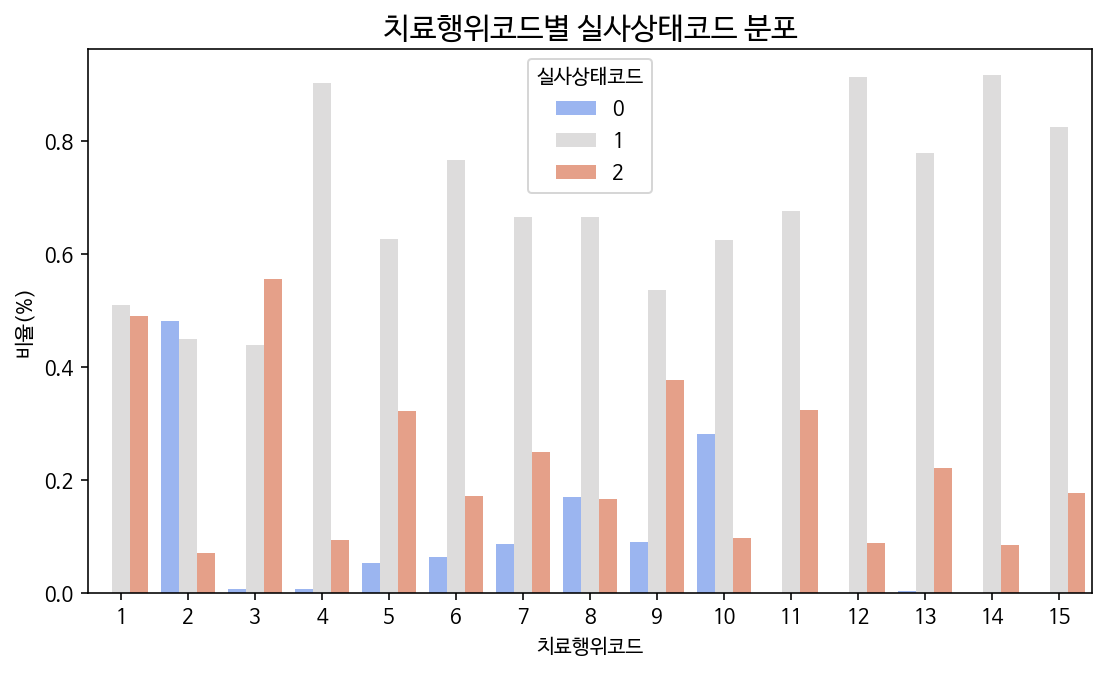

In [ ]:
plt.figure(figsize=(9,5))
bar_stack_target(train,'치료행위코드')

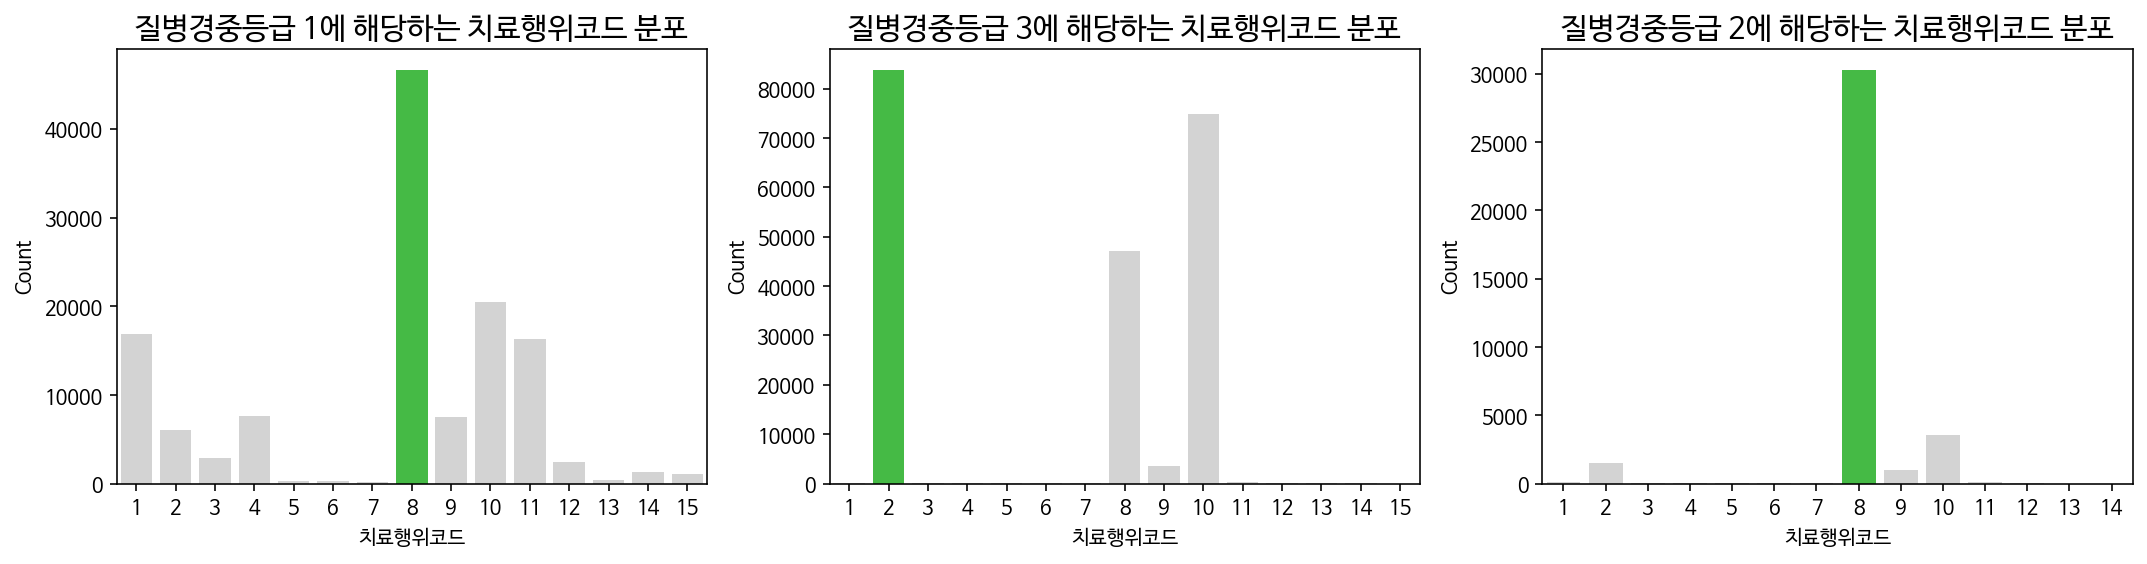

In [ ]:
plt.figure(figsize=(15,4))
for i,cat in enumerate(train['질병경중등급코드'].unique()):
  ax=plt.subplot(1,3,i+1)
  cure_code=train[train['질병경중등급코드']==cat].groupby(['치료행위코드'])['접수년월'].count().reset_index().rename(columns={'접수년월':'Count'})
  colors=['limegreen' if (x == max(cure_code['Count']))
        else 'lightgrey'  for x in cure_code['Count']]
  sns.barplot(data=cure_code,x='치료행위코드',y='Count',palette=colors,ax=ax); plt.title(f'질병경중등급 {cat}에 해당하는 치료행위코드 분포',fontsize=15)
  plt.tight_layout()
plt.show()

#### 3) 질병 - Continuous data

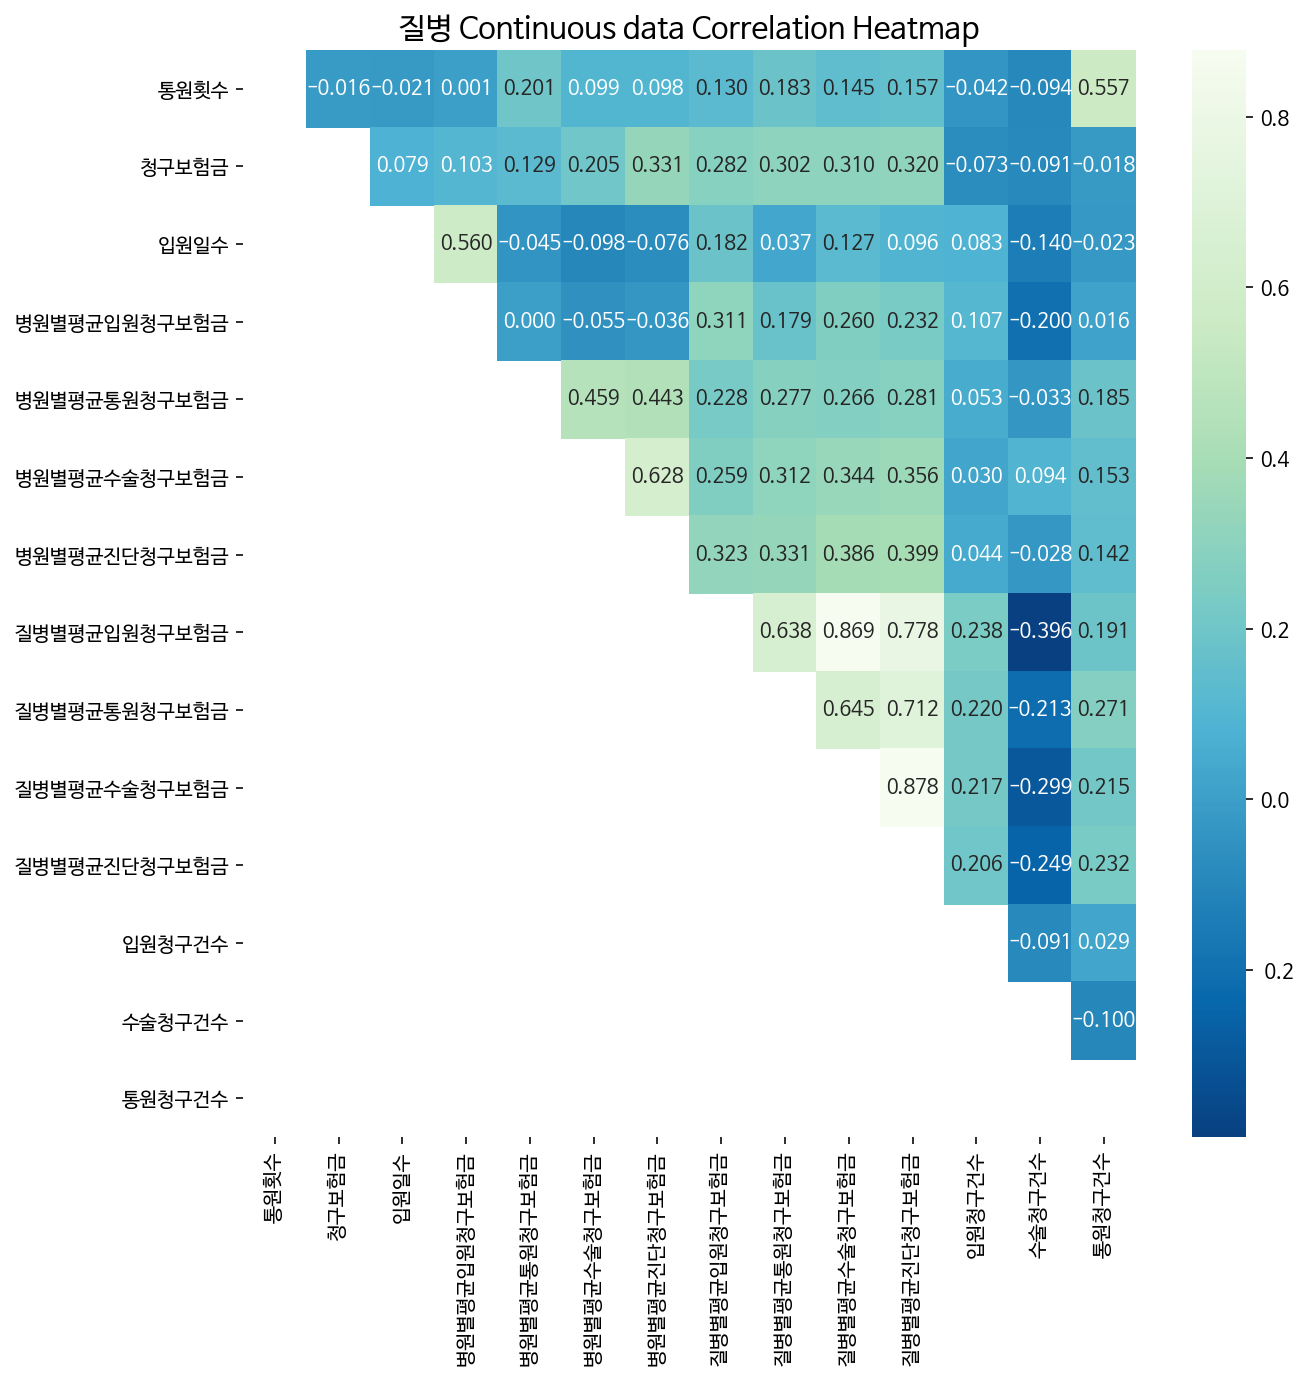

In [ ]:
corr_mat=train[disease_conti].corr()
mask=np.zeros_like(corr_mat,dtype=np.bool)
mask[np.tril_indices_from(mask)]=True

plt.figure(figsize=(10,10))
sns.heatmap(corr_mat,annot=True,cmap='GnBu_r',mask=mask,fmt='.3f')
plt.title('질병 Continuous data Correlation Heatmap',fontsize=15)
plt.show()

In [ ]:
# 높은 correlation 보이는 column 제거
upper=corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(np.bool))
to_drop=[col for col in upper.columns if any(abs(upper[col])>0.8)]
to_drop

['질병별평균수술청구보험금', '질병별평균진단청구보험금']

Text(0.5, 1.0, '질병별평균보험금 분포')

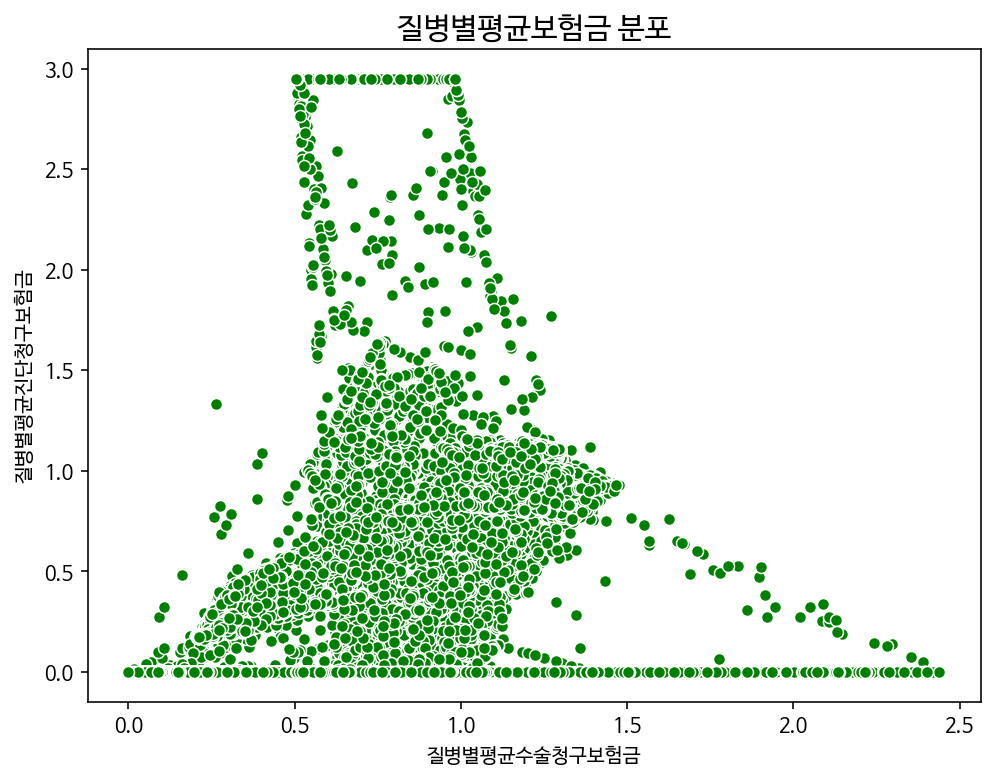

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=train, x='질병별평균수술청구보험금', y='질병별평균진단청구보험금',color='green')
plt.title('질병별평균보험금 분포',fontsize=15)

## 3. Feature Engineering